In [ ]:
#install pyspark
!pip install pyspark

In [44]:
#Imports
from google.cloud import bigquery

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, regexp_replace,trim
client = bigquery.Client()

In [70]:
# SparkSession
spark = SparkSession.builder \
    .appName("Análise de Dados COVID") \
    .getOrCreate()

# Ler a base de dados a partir do CSV
df = spark.read.csv('/content/base_final.csv', header=True, inferSchema=True, sep=',')

df.show(5)

+------------+--------------------+-------------------+--------------------+--------------------+--------------------+---------+--------+--------+
|pk_indicador|           indicador|variavel_abertura_1|categoria_abertura_1| variavel_abertura_2|categoria_abertura_2|     Maio|   Junho|   julho|
+------------+--------------------+-------------------+--------------------+--------------------+--------------------+---------+--------+--------+
|         107|Pessoas que apres...|               Sexo|               Homem|Procura a estabel...|Não foi a estabel...|   8 734 |  5 379 |  4 554 |
|         107|Pessoas que apres...|               Sexo|               Homem|                NULL|                NULL|  10 407 |  6 685 |  5 888 |
|         107|Pessoas que apres...|               Sexo|               Homem|Procura a estabel...|Foi a estabelecim...|   1 671 |  1 306 |  1 330 |
|         107|Pessoas que apres...|        Cor ou Raça|              Branca|Procura a estabel...|Não foi a estabel...|

Das pessoas que apresentaram os sintomas perda de cheiro ou de sabor existe um sexo ou grupo de idade que tem maior tendência ter esses sintomas?


In [66]:
#Criando todos os dataframes filtrados
df.createOrReplaceTempView("dados_covid")

df_108_genero = spark.sql("""
    SELECT
        variavel_abertura_1
        ,categoria_abertura_1
        ,maio
        ,junho
        ,julho
    FROM
        dados_covid
    WHERE
        pk_indicador = 108 AND
        variavel_abertura_1 = 'Sexo'
    LIMIT 1000
""")

df_108_idade = spark.sql("""
    SELECT
        variavel_abertura_1
        ,categoria_abertura_1
        ,maio
        ,junho
        ,julho
    FROM
        dados_covid
    WHERE
        pk_indicador = 108 AND
        variavel_abertura_1 = ("Grupos de Idade")
    LIMIT 1000
""")

df_106_comorbidade = spark.sql("""
    SELECT
        variavel_abertura_2,
        categoria_abertura_2,
        maio,
        junho,
        julho
    FROM
        dados_covid
    WHERE
        pk_indicador = 106 AND
        variavel_abertura_2 = "Tipo de comorbidade"
    LIMIT 1000
""")

df_106_comorbidade.show(10)


# Mostrar os resultados
df_108_genero.show(2, truncate=False)
df_108_idade.show(10, truncate=False)

+-------------------+--------------------+----+-----+-----+
|variavel_abertura_2|categoria_abertura_2|maio|junho|julho|
+-------------------+--------------------+----+-----+-----+
+-------------------+--------------------+----+-----+-----+

+-------------------+--------------------+--------+--------+--------+
|variavel_abertura_1|categoria_abertura_1|maio    |junho   |julho   |
+-------------------+--------------------+--------+--------+--------+
|Sexo               |Homem               |  1 619 |   898  |   740  |
|Sexo               |Mulher              |  2 251 |  1 258 |  1 046 |
+-------------------+--------------------+--------+--------+--------+
only showing top 2 rows

+-------------------+--------------------+--------+--------+-------+
|variavel_abertura_1|categoria_abertura_1|maio    |junho   |julho  |
+-------------------+--------------------+--------+--------+-------+
|Grupos de Idade    |0 a 9 anos          |   94   |   66   |   45  |
|Grupos de Idade    |10 a 19 anos     

Por genero!!

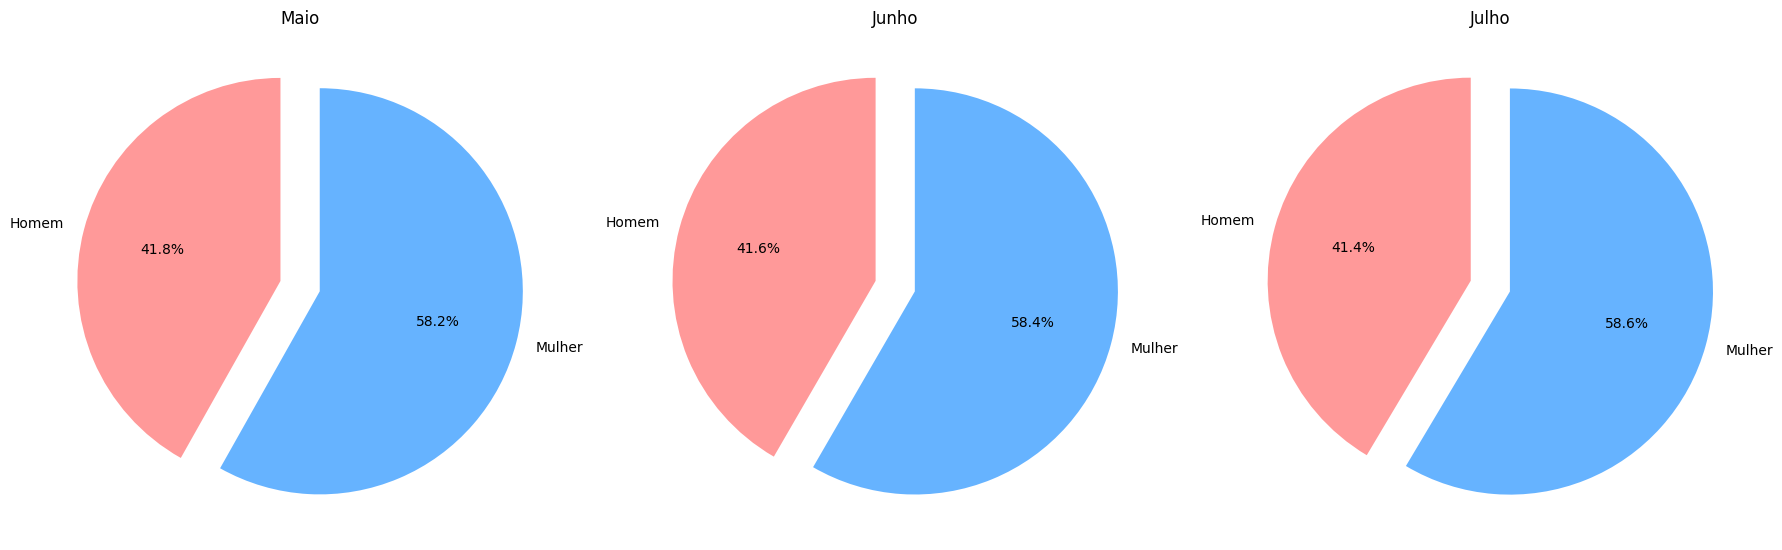

In [57]:
df_resultado = df_108_genero.toPandas()

df_resultado['maio'] = df_resultado['maio'].astype(str).str.replace(' ', '').astype(int)
df_resultado['junho'] = df_resultado['junho'].astype(str).str.replace(' ', '').astype(int)
df_resultado['julho'] = df_resultado['julho'].astype(str).str.replace(' ', '').astype(int)

dados = df_resultado.groupby('categoria_abertura_1')[['maio', 'junho', 'julho']].sum().reset_index()

generos = dados['categoria_abertura_1'].values
dados_dict = {
        'Maio': dados['maio'].values,
        'Junho': dados['junho'].values,
        'Julho': dados['julho'].values
    }

cores = ['#ff9999', '#66b3ff']

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

explode = [0.1] * len(generos)

for i, mes in enumerate(dados_dict.keys()):
    axs[i].pie(dados_dict[mes], labels=generos, colors=cores, autopct='%1.1f%%', startangle=90, explode=explode)
    axs[i].set_title(f'{mes}')

plt.tight_layout()
plt.show()

Por Grupo de idade

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

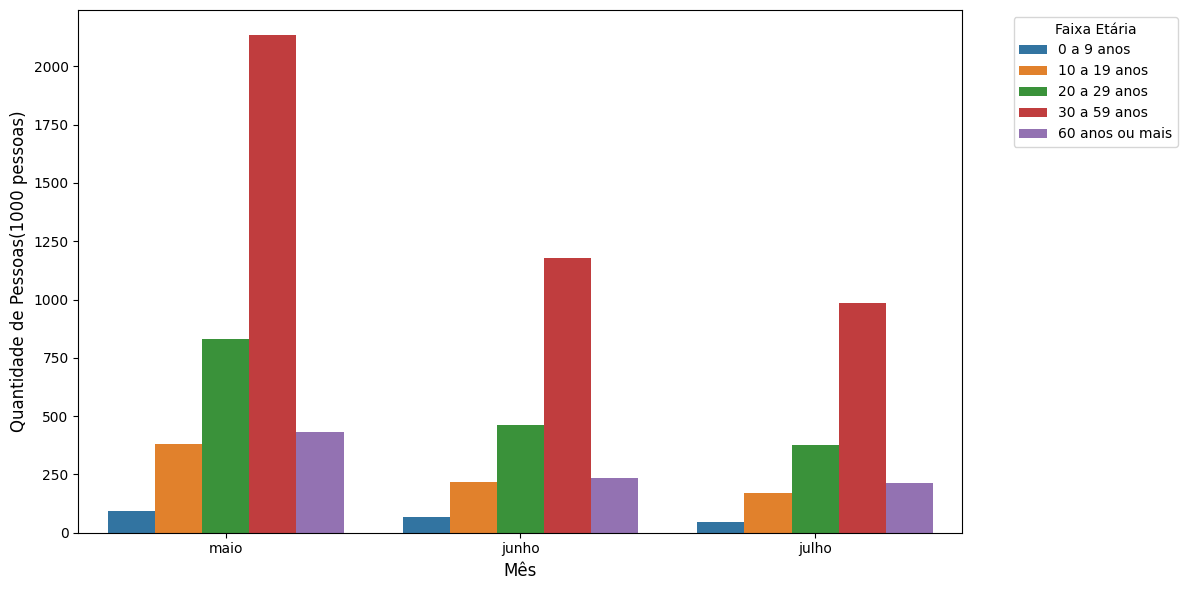

In [62]:
df_resultado = df_108_idade.toPandas()

df_resultado['maio'] = df_resultado['maio'].astype(str).str.replace(' ', '').astype(int)
df_resultado['junho'] = df_resultado['junho'].astype(str).str.replace(' ', '').astype(int)
df_resultado['julho'] = df_resultado['julho'].astype(str).str.replace(' ', '').astype(int)

dados = df_resultado.groupby('categoria_abertura_1')[['maio', 'junho', 'julho']].sum().reset_index()

generos = dados['categoria_abertura_1'].values
dados_dict = {
        'Maio': dados['maio'].values,
        'Junho': dados['junho'].values,
        'Julho': dados['julho'].values
    }

df_melted = pd.melt(df_resultado, id_vars=['categoria_abertura_1'],
                        value_vars=['maio', 'junho', 'julho'],
                        var_name='Mês',
                        value_name='Quantidade')

plt.figure(figsize=(12, 6))
sns.barplot(x='Mês', y='Quantidade', hue='categoria_abertura_1', data=df_melted)

plt.ylabel('Quantidade de Pessoas(1000 pessoas)', fontsize=12)
plt.xlabel('Mês', fontsize=12)

plt.legend(title='Faixa Etária', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



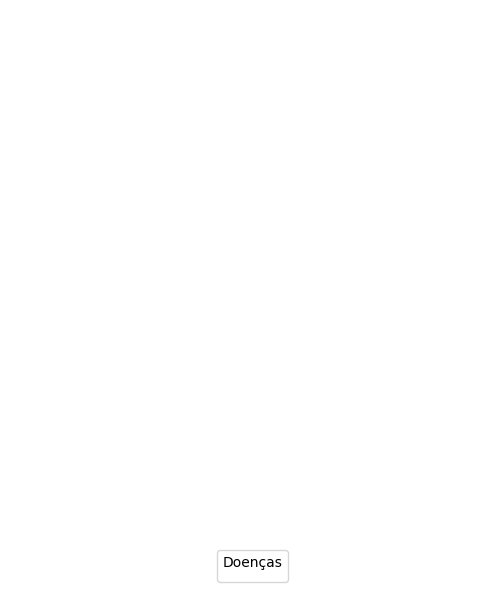

In [71]:
df_resultado = df_106_comorbidade.toPandas()

df_resultado['maio'] = df_resultado['maio'].astype(str).str.replace(' ', '').astype(int)
df_resultado['junho'] = df_resultado['junho'].astype(str).str.replace(' ', '').astype(int)
df_resultado['julho'] = df_resultado['julho'].astype(str).str.replace(' ', '').astype(int)

dados = df_resultado.groupby('categoria_abertura_2')[['maio', 'junho', 'julho']].sum().reset_index()

labels = dados['categoria_abertura_2'].values
sizes = dados['julho'].values
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6']

fig, ax = plt.subplots(figsize=(12, 6))
ax.pie(sizes, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85)

plt.legend(labels, title="Doenças", loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)

plt.tight_layout()

plt.show()
